In [2]:
# Calculation of complete reporting rates with program and stock data

%matplotlib inline  
# !pip install matplotlib

import pandas as pd
import numpy as np
import pandas_highcharts.core
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot 

# weird construct - if you don't from * import * you have to use datetime.datetime in commands
from datetime import datetime, date, timedelta

import os


os.environ.setdefault("DJANGO_SETTINGS_MODULE", "IMAM.settings")

from django.conf import settings
from home.management.commands.load_data import rename_cols, assign_state_lga_num

import django
django.setup()

# is this line necessary?
from home.models import Program, Stock, Site

In [3]:
# Import Program Data
engine = create_engine(
    'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{NAME}'.format(**settings.DATABASES['default']))
df = pd.read_sql_query("select * from program;", con=engine)

In [270]:
!pip install isoweek

In [4]:
# Follow order for cleaning data for graph
#  - convert from string to float
#  - filter out incorrect data with query
#  - convert from float to int

df['siteid'] = pd.to_numeric(df.siteid, errors='coerce')
df['weeknum'] = pd.to_numeric(df.weeknum, errors='coerce')

df = df.query('siteid==siteid').query('0<siteid<3999990999')
# 2015 had 53 weeks
# 2016 had 52 weeks - current data is only for weeknumbers from 22-2016 to present
df = df.query('weeknum==weeknum').query('0.99<weeknum<53')

df['siteid'] = df.siteid.astype('int')
df['weeknum'] = df.weeknum.astype('int')

In [5]:
# Before filter - Sort data
df = df.sort_values(by='last_seen', ascending = False)
len(df)

36052

In [6]:
# Filter one entry per weeknum
df = df.drop_duplicates(['siteid', 'weeknum', 'type'], keep ='first')
len(df)

24168

In [7]:
# count of number of rows with each unique value of var
df.type.value_counts()

OTP    21963
SC      1870
Name: type, dtype: int64

In [8]:
# number of distinct values in column
len(df['type'].unique())

3

In [9]:
# the unique values for var in column
df.type.unique()

array([u'OTP', None, u'SC'], dtype=object)

In [11]:
df.confirm.value_counts()

Yes      29553
No        1892
Other      181
X            2
Name: confirm, dtype: int64

In [ ]:
# to make reporting rates need to identify all data in past 8 weeks

# create today's weeknum

# create weeknum / year of report date

#for range in todays weeknum-8 to todays weeknum
#   count number of valid reports for program and stocks
#   divide total over 16 (8 entries for program and 8 for stock)

In [319]:
# create today's weeknum
df.curr_weeknum = datetime.now().isocalendar()[1]

#print curr_weeknum
df.curr_weeknum



13

In [9]:
# print datetime.now(), type(datetime.now())
# 2017-03-29 15:32:15.342119 

#df.last_seen
# 2017-03-20 07:12:32

#datetime and numpy date64 appear the same

#rep_week = date(2017, 1, 1).isocalendar()
#rep_week

#df.rep_weeknum = date(df.last_seen).strftime("%V")
#df.rep_weeknum = date(df.last_seen).isocalendar()
# cannot use python commands on dataframes ?

#df=df.assign(rep_weeknum=lambda df: date(df.last_seen).isocalendar())

# this did not work when test, but now appears to work
df['rep_year_wn'] = df['last_seen'].map(lambda x: x.isocalendar())

#import time
#from time import gmtime, strftime
#df.rep_weeknum = time(df.last_seen, "%Y %m %d")
# print(strftime("%W", df.rep_weeknum))

# This works but is a hack because there is an error between year and week number
df['rep_year'] = df['last_seen'].map(lambda x: x.to_pydatetime().isocalendar()[0])

# double check if the week number below is ISO standard
# I don't know the reference for week below, but appears to be ISO week
df['rep_weeknum'] = df['last_seen'].map(lambda x: x.to_pydatetime().isocalendar()[1])
                                        
# Isocalendar is better to use as it tracks (year, weeknum, day of week)                                        

In [10]:
df['last_seen'][0]

Timestamp('2016-10-06 17:01:37')

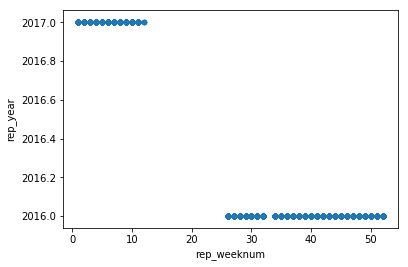

In [11]:
df.plot.scatter(x='rep_weeknum', y='rep_year')
# problem with week number 52 year 2017

In [12]:
# clean data

# delete all future reporting - 10 am
df['last_seen_dotw'] = df['last_seen'].map(lambda x: x.to_pydatetime().isocalendar()[2])
df['last_seen_hour'] = df['last_seen'].map(lambda x: x.to_pydatetime().hour)
#df.query('last_seen_dotw==1').query('last_seen_hour<10').query('rep_weeknum==weeknum')['name'].groupby(df['name']).count().plot(kind='bar', rot=90)
bad_index = df.query('last_seen_dotw==1').query('last_seen_hour<10').query('rep_weeknum==weeknum').index.tolist()


# print df.count()
df = df[~df.index.isin(bad_index)]

In [13]:
# remove reports for before 8 weeks

df['last_seen_weeknum_8weekago'] = df['last_seen'].map(lambda x: (x.to_pydatetime() - timedelta(weeks=8)).isocalendar()[1])

In [14]:
(9 - 46) % 52

15

In [15]:
df.head()

,index,contact_uuid,urn,name,groups,siteid,first_seen,last_seen,weeknum,role,...,dmed,tout,confirm,unique,rep_year_wn,rep_year,rep_weeknum,last_seen_dotw,last_seen_hour,last_seen_weeknum_8weekago
34607,34499,1fed4097-3edb-44ec-a04d-3dd8fd0f46a7,2348068838496,Hussain Umar Zamni.,"Imam Supervision, Imam Supervision 2, Imam Sup...",818110008,2017-03-20 07:10:19,2017-03-20 07:12:32,11,Site,...,None,None,None,2348068838496 2017-03-20 07:10:19,"(2017, 12, 1)",2017,12,1,7,4
27735,27625,893376dd-9df2-4a91-8f21-5e68cf724b41,2347069118684,Samaila Sulaiman .,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603210001,2017-03-20 07:10:08,2017-03-20 07:12:30,8,Site,...,None,None,None,2347069118684 2017-03-20 07:10:08,"(2017, 12, 1)",2017,12,1,7,4
28082,27970,d745fc85-ffae-4cfc-935c-267a16bd7bca,2348067698638,Nafiu Bello.,"Imam Supervision, Imam Supervision 2, Imam Sup...",3605110051,2017-03-20 07:04:00,2017-03-20 07:10:05,11,Site,...,0.0,2,Yes,2348067698638 2017-03-20 07:04:00,"(2017, 12, 1)",2017,12,1,7,4
25619,25522,eadd9870-9e6a-483d-9669-97291071efe5,2347031104215,Abdullah Maaruf.,"AlertRUTF, Imam Supervision, Imam Supervision ...",2034110031,2017-03-20 06:42:09,2017-03-20 06:46:13,11,Site,...,0,0,Yes,2347031104215 2017-03-20 06:42:09,"(2017, 12, 1)",2017,12,1,6,4
3979,3959,c6ace209-1c2e-46f2-b008-950715e39df2,2348166722275,Abdulwahab Ismail.,"Imam Supervision, Imam Supervision 2, Imam Sup...",1606110027,2017-03-19 22:47:40,2017-03-19 23:16:51,11,Site,...,1,0,Yes,2348166722275 2017-03-19 22:47:40,"(2017, 11, 7)",2017,11,7,23,3


In [207]:
# Corrected Year Error with to_pydatetime

# if all else fails
# split out year, month, day to feed into datetime
# and convert from string to int
date = "2017-03-29 15:32:15.342119"
year, month, day = date.split('-')
day = day[0:2]
print year, type(year)
print month, type(year)
print day, type(year)

2017 <type 'str'>
03 <type 'str'>
29 <type 'str'>


In [18]:
df['year'] = df['last_seen'].map(lambda x: x.year)

df['last_seen_weeknum'] = df['last_seen'].map(lambda x: x.week)
df['year'] = np.where(df['last_seen_weeknum'] < df['weeknum'],
                                        df['year'] - 1, df['year'])

df['year_weeknum'] = zip(df['year'], df['weeknum'])

In [17]:
# from isoweek import Week
# w = Week(2011, 20)

from isoweek import Week
df['iso_rep_year_wn'] = df['rep_year_wn'].map(lambda x: Week(x[0], x[1]))

df['iso_year_weeknum'] = df['year_weeknum'].map(lambda x: Week(x[0], x[1]))

In [19]:
bad_index2 = df.query('rep_year_wn<year_weeknum').index.tolist()
df = df[~df.index.isin(bad_index2)]

In [20]:
# this mean that iso week comparison yield the sane result than tuple comparison
((df['iso_rep_year_wn'] >= df['iso_year_weeknum']) == (df['rep_year_wn'] >= df['year_weeknum'])).describe()

count     24111
unique        1
top        True
freq      24111
dtype: object

In [21]:
df['iso_diff'] = (df['iso_year_weeknum'] - df['iso_rep_year_wn'] )
df['iso_diff'].groupby(df['iso_diff']).count().describe()

count      52.000000
mean      463.673077
std      1346.973976
min         1.000000
25%         5.750000
50%        14.500000
75%        76.000000
max      7848.000000
Name: iso_diff, dtype: float64

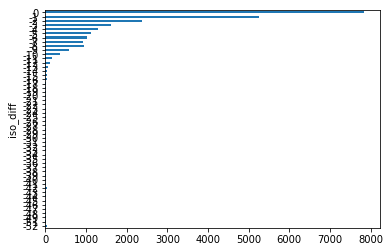

In [22]:
df['iso_diff'].groupby(df['iso_diff']).count().plot.barh()

In [332]:
df['iso_diff'].groupby(df['iso_diff']).count()

iso_diff
-52      45
-51       4
-49       1
-48       9
-47       5
-46       1
-45       2
-44       9
-43      17
-42      27
-41      14
-40      18
-39      12
-38       4
-37       2
-36       3
-35      13
-34       8
-33       8
-32       2
-31       2
-30       4
-29       5
-28       5
-27      11
-26       6
-25      15
-24       6
-23       7
-22      14
-21      11
-20      16
-19      19
-18      21
-17      24
-16      32
-15      30
-14      40
-13      68
-12     100
-11     166
-10     346
-9      573
-8      952
-7      920
-6     1012
-5     1115
-4     1284
-3     1612
-2     2382
-1     5261
 0     7848
Name: iso_diff, dtype: int64

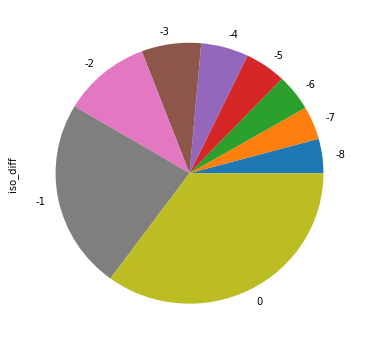

In [338]:
df.query('iso_diff>=-8')['iso_diff'].groupby(df['iso_diff']).count().plot.pie(figsize=(6, 6))
# reporting by the day of the week


In [33]:
year, week, dotw = date.today().isocalendar()
current_week = Week(year, week)

# since how many week this report is about
df['since_x_weeks'] = df['iso_year_weeknum'].map(lambda x: current_week - x)

In [37]:
df.query('since_x_weeks<=8')['since_x_weeks']

34607    2
27735    5
28082    2
25619    2
3979     2
27817    2
20069    2
911      2
27816    3
19641    4
28551    2
19640    8
4543     2
10485    2
20143    2
20142    3
3900     2
20141    4
20140    5
27734    6
34532    2
27563    2
13539    3
32246    2
27732    7
26778    2
14672    2
14770    2
26777    3
25921    2
        ..
34116    8
25969    8
17875    8
21485    8
34069    8
1762     8
8080     8
11159    8
33919    8
22146    8
28581    8
13262    8
4951     8
23490    8
30137    8
24536    8
26929    8
3853     8
28166    8
18564    8
26558    8
36120    8
27147    8
20976    8
6096     8
17714    8
27677    8
10221    8
25429    8
5488     8
Name: since_x_weeks, dtype: int64

In [51]:
df.query('since_x_weeks<=8').query('siteid>101110001').groupby(df['siteid'])['weeknum'].unique()

siteid
201110007             [9, 8, 7, 6, 5]
201110009         [10, 9, 8, 7, 6, 5]
201110026             [9, 8, 7, 6, 5]
201110029            [10, 8, 7, 6, 5]
201410014        [11, 10, 9, 7, 6, 5]
202110019                [8, 7, 6, 5]
202110021     [11, 10, 9, 8, 7, 6, 5]
202110027     [11, 10, 9, 8, 7, 6, 5]
202110035     [11, 10, 9, 8, 7, 6, 5]
202110068         [10, 9, 8, 7, 6, 5]
202610001             [9, 8, 7, 6, 5]
203110002     [11, 10, 9, 8, 7, 6, 5]
203110037     [11, 10, 9, 8, 7, 6, 5]
203110038     [11, 10, 9, 8, 7, 6, 5]
203110043     [11, 10, 9, 8, 7, 6, 5]
203110053     [11, 10, 9, 8, 7, 6, 5]
204110006         [10, 9, 8, 7, 6, 5]
204110014             [9, 5, 8, 7, 6]
204110026         [10, 9, 8, 7, 6, 5]
204110029     [11, 10, 9, 8, 7, 6, 5]
204110035     [11, 10, 9, 8, 7, 6, 5]
205110025         [10, 9, 8, 7, 6, 5]
205110030                [8, 7, 6, 5]
206110004     [11, 10, 9, 8, 7, 6, 5]
206110011     [11, 10, 9, 8, 7, 6, 5]
206110020         [10, 9, 8, 7, 6, 5]
20611

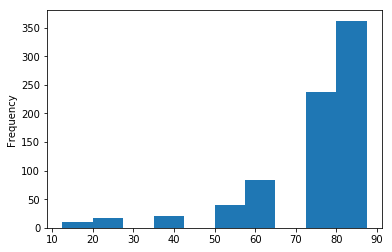

In [49]:
df.query('since_x_weeks<=8').query('siteid>101110001').groupby(df['siteid'])['weeknum'].unique().map(lambda x: (len(x) / 8.) * 100).plot.hist()

In [52]:
set(range(5, 13))

{5, 6, 7, 8, 9, 10, 11, 12}

In [53]:
# set operation to calculate missing report week nubers
set(range(5, 13)) - set([9, 8, 7, 6, 5])

{10, 11, 12}

In [54]:
week = date.today().isocalendar()[1]
range(week - 8, week)

[5, 6, 7, 8, 9, 10, 11, 12]

In [55]:
# making things generic
set(range(week - 8, week)) - set([9, 8, 7, 6, 5])

{10, 11, 12}

In [61]:
# missing weeks
df.query('since_x_weeks<=8').query('siteid>101110001').groupby(df['siteid'])['weeknum'].unique().map(lambda x: set(range(week - 8, week)) - set(x))

siteid
201110007                 {10, 11, 12}
201110009                     {11, 12}
201110026                 {10, 11, 12}
201110029                  {9, 11, 12}
201410014                      {8, 12}
202110019              {9, 10, 11, 12}
202110021                         {12}
202110027                         {12}
202110035                         {12}
202110068                     {11, 12}
202610001                 {10, 11, 12}
203110002                         {12}
203110037                         {12}
203110038                         {12}
203110043                         {12}
203110053                         {12}
204110006                     {11, 12}
204110014                 {10, 11, 12}
204110026                     {11, 12}
204110029                         {12}
204110035                         {12}
205110025                     {11, 12}
205110030              {9, 10, 11, 12}
206110004                         {12}
206110011                         {12}
206110020         

In [70]:
# percentage of complet reporting for one site
df.query('since_x_weeks<=8').query('siteid>101110001').query('3611110033==siteid').groupby(df['siteid'])['weeknum'].unique().map(lambda x: (len(x) / 8.) * 100).tolist()[0]

62.5

In [77]:
(5 / 8.) * 100

62.5

In [71]:
df['since_x_weeks'].max()

91

In [81]:
for i in range(0, df['since_x_weeks'].max()):
    print i, df.query('%s<since_x_weeks<=%s' % (i, i + 8)).query('siteid>101110001').query('3611110033==siteid').groupby(df['siteid'])['weeknum'].unique().map(lambda x: (len(x) / 8.) * 100).tolist()

0 [62.5]
1 [75.0]
2 [87.5]
3 [100.0]
4 [100.0]
5 [100.0]
6 [100.0]
7 [100.0]
8 [100.0]
9 [100.0]
10 [100.0]
11 [100.0]
12 [100.0]
13 [100.0]
14 [100.0]
15 [100.0]
16 [100.0]
17 [100.0]
18 [100.0]
19 [100.0]
20 [100.0]
21 [100.0]
22 [87.5]
23 [75.0]
24 [62.5]
25 [50.0]
26 [37.5]
27 [25.0]
28 [12.5]
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70 []
71 []
72 []
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 []


In [29]:
52 / 8.

6.5

In [108]:
df.head()

,index,contact_uuid,urn,name,groups,siteid,first_seen,last_seen,weeknum,role,...,tin,dcur,dead,defu,dmed,tout,confirm,unique,rep_weeknum,rep_year
34607,34499,1fed4097-3edb-44ec-a04d-3dd8fd0f46a7,2348068838496,Hussain Umar Zamni.,"Imam Supervision, Imam Supervision 2, Imam Sup...",818110008,2017-03-20 07:10:19,2017-03-20 07:12:32,11,Site,...,0,None,None,None,None,None,None,2348068838496 2017-03-20 07:10:19,12,2017
27735,27625,893376dd-9df2-4a91-8f21-5e68cf724b41,2347069118684,Samaila Sulaiman .,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603210001,2017-03-20 07:10:08,2017-03-20 07:12:30,8,Site,...,0,None,None,None,None,None,None,2347069118684 2017-03-20 07:10:08,12,2017
28082,27970,d745fc85-ffae-4cfc-935c-267a16bd7bca,2348067698638,Nafiu Bello.,"Imam Supervision, Imam Supervision 2, Imam Sup...",3605110051,2017-03-20 07:04:00,2017-03-20 07:10:05,11,Site,...,0,2.0,0.0,0.0,0.0,2,Yes,2348067698638 2017-03-20 07:04:00,12,2017
25619,25522,eadd9870-9e6a-483d-9669-97291071efe5,2347031104215,Abdullah Maaruf.,"AlertRUTF, Imam Supervision, Imam Supervision ...",2034110031,2017-03-20 06:42:09,2017-03-20 06:46:13,11,Site,...,0,0,0,0,0,0,Yes,2347031104215 2017-03-20 06:42:09,12,2017
3979,3959,c6ace209-1c2e-46f2-b008-950715e39df2,2348166722275,Abdulwahab Ismail.,"Imam Supervision, Imam Supervision 2, Imam Sup...",1606110027,2017-03-19 22:47:40,2017-03-19 23:16:51,11,Site,...,0,6,0,0,1,0,Yes,2348166722275 2017-03-19 22:47:40,11,2017


In [23]:
df['rep_iso'] = df['last_seen'].map(lambda x: x.isocalendar())
# why is this working now and not yesterday ? 

In [24]:
df['rep_iso'].head()

34607    (2017, 12, 1)
27735    (2017, 12, 1)
28082    (2017, 12, 1)
25619    (2017, 12, 1)
3979     (2017, 11, 7)
Name: rep_iso, dtype: object

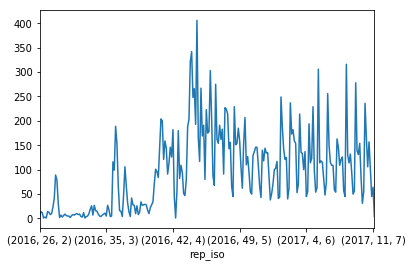

In [208]:
entries_by_week = df['rep_iso'].groupby(df['rep_iso']).count()
entries_by_week.plot()
# here can see the sine wave related to reporting by week day

In [183]:
# calculate ISO year, weeknum, day for var weeknum



# take first value (year) out of rep_weeknum (year, weeknum, day)
df['rep_year'] = df['last_seen'].map(lambda x: x.isocalendar()[0])
df['rep_weeknum'] = df['last_seen'].map(lambda x: x.isocalendar()[1])

df['rep_weeknum'].unique()

array([12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1, 52, 51, 50, 49, 48,
       47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 32, 31, 30,
       29, 28, 27, 26])

In [ ]:
firstjan = datetime(2010, 1, 1).isocalendar()
fourjan = datetime(2010, 1, 4).isocalendar()
print firstjan, type(firstjan)
print fourjan
#print fourjan - firstjan
# Cannot add and subtract from two instances of isocalendar

In [150]:
# to extract a date from isocalendar tuple
# in python 3.6
# datetime.strptime('2010 1 1','%G %V %u').date()

# Create an isocalendar tuple and assign it to isocalendar format
#df['weeknum_date'] = datetime(df['rep_year'],df['weeknum'],1).isocalendar()
#df['weeknum_date'] = datetime(df['rep_year'],df['weeknum'],1).map(lambda x: x.isocalendar())
# Is weeknum a string? NO - This is not the problem
# isocalendar takes a date as input
df['year_wn'] =list(zip(df['rep_year'], df['weeknum']))

In [162]:
# Either create two dates and subtract, or
# subtract the rep_week from weeknum and correct the year

# create date from week number
d = "2017-W1"
r = datetime.strptime(d + '-0', "%Y-W%W-%w")
print r
# does not use ISO week numbers - do not use

#from isoweek import Week
#w = Week(2016, 52)
#print "Week %s starts on %s" % (w, w.monday())
# no module named isoweek

2017-01-08 00:00:00


In [210]:
# to convert iso week number to correct date 
# either change to Python 3.6 or
# calculate first week of year and then convert week number to date, correcting year. 

df['weekdiff'] = df.weeknum - df.rep_weeknum 
# When creating new variables, you cannot refer to the new variable as df.weekdiff

# Change the order (the index) of the columns
columnsTitles = ['weeknum',
                'rep_weeknum',
                 'weekdiff']

df2 = df.reindex(columns=columnsTitles)
df2

,weeknum,rep_weeknum,weekdiff
34607,11,12,-1
27735,8,12,-4
28082,11,12,-1
25619,11,12,-1
3979,11,11,0
27817,11,11,0
20069,11,11,0
911,11,11,0
27816,10,11,-1
19641,9,11,-2


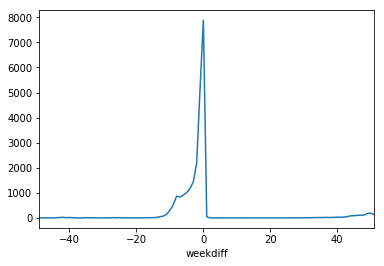

In [211]:
# Univariate plot of values by count of value
wd = df['weekdiff'].groupby(df['weekdiff']).count()
wd.plot()
# have to correct the values that are near weeknum 46

In [189]:
print wd

weekdiff
-49      1
-48      8
-47      2
-45      1
-44      8
-43     15
-42     26
-41     10
-40     18
-39     11
-38      3
-37      1
-36      2
-35     11
-34      7
-33      7
-32      2
-31      1
-30      2
-29      3
-28      3
-27     10
-26      3
-25     13
-24      3
-23      2
-22      6
-21      4
-20      7
-19      5
      ... 
 22      2
 23      2
 24      2
 25      1
 26      3
 27      3
 28      3
 29      5
 30      8
 31      7
 32      9
 33     14
 34     16
 35     15
 36     22
 37     19
 38     19
 39     21
 40     28
 41     25
 42     38
 43     51
 44     84
 45     90
 46    103
 47    110
 48    116
 49    172
 50    195
 51    127
Name: weekdiff, dtype: int64


In [ ]:
# test if report is made in past, current time or future.

# calculate 8 weeks into past


In [196]:
df.year_wn.head()

34607    (2017, 11)
27735     (2017, 8)
28082    (2017, 11)
25619    (2017, 11)
3979     (2017, 11)
Name: year_wn, dtype: object